In [10]:
# Import
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Plot parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()

In [13]:
# IMPORT CLASSIFIER
from src.classifiers import softmax

# INITIALIZE CLASSIFIER
length = X_train.shape[1]
classifier = softmax(length,10)

# GRADIENT AND LOSS CHECK
W = np.random.randn(3073, 10) * 0.0001
loss, grad = classifier.cross_entropy_loss(W, X_dev, y_dev, 0.0)
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.282716
sanity check: 2.302585


In [15]:
# IMPORT GRAD CHECK
from cs231n.gradient_check import grad_check_sparse

# WITHOUT REGULARIZATION
loss, grad = classifier.cross_entropy_loss(W, X_dev, y_dev, 0.0)
f = lambda w: classifier.cross_entropy_loss(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# WITH REGULARIZATION
loss, grad = classifier.cross_entropy_loss(W, X_dev, y_dev, 1e2)
f = lambda w: classifier.cross_entropy_loss(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.825741 analytic: -0.825741, relative error: 9.898032e-09
numerical: -0.974779 analytic: -0.974779, relative error: 5.212988e-09
numerical: 2.641424 analytic: 2.641424, relative error: 4.272980e-08
numerical: -0.626342 analytic: -0.626342, relative error: 1.626263e-07
numerical: 0.067849 analytic: 0.067849, relative error: 1.896693e-07
numerical: -1.786262 analytic: -1.786262, relative error: 5.793002e-09
numerical: -0.991761 analytic: -0.991761, relative error: 2.640926e-08
numerical: 2.087935 analytic: 2.087935, relative error: 7.250897e-09
numerical: -0.027866 analytic: -0.027866, relative error: 4.167629e-07
numerical: -1.362787 analytic: -1.362787, relative error: 3.798891e-08
numerical: 0.817396 analytic: 0.817396, relative error: 2.948349e-08
numerical: 0.757943 analytic: 0.757943, relative error: 1.697551e-08
numerical: -2.091637 analytic: -2.091637, relative error: 2.913722e-09
numerical: 0.849829 analytic: 0.849829, relative error: 2.916789e-08
numerical: 0.55195

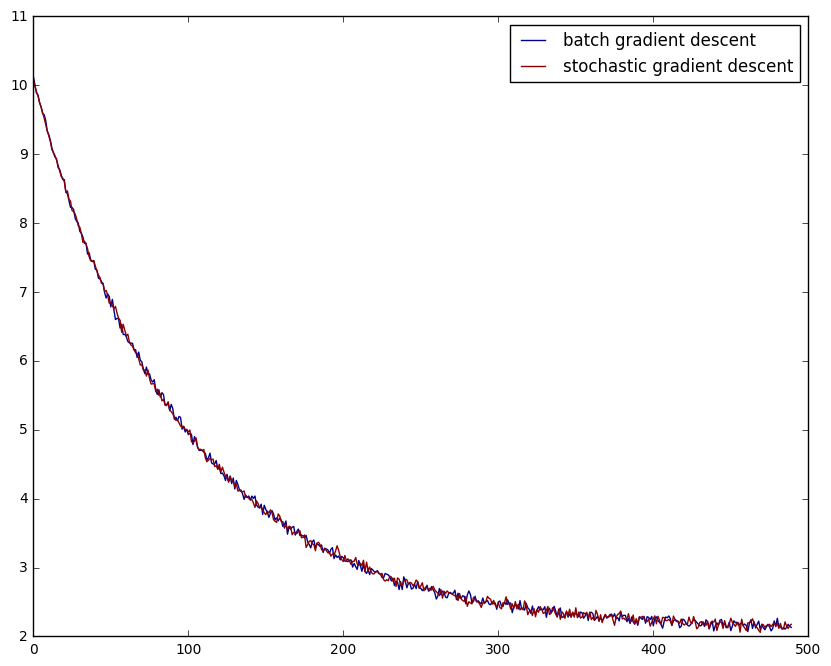

In [23]:
loss_hist = classifier.train(X_train,y_train)
loss_hist_stochastic = classifier.train(X_train,y_train,grad="stochastic")
xvals = np.arange(len(loss_hist))
plt.plot(xvals,loss_hist,color="darkblue",label="batch gradient descent")
plt.plot(xvals,loss_hist_stochastic,color="darkred",label="stochastic gradient descent")
plt.legend()

In [24]:
# INITIALIZE LEARNING RATES
learning_rates = np.linspace(1e-8, 5e-6,8)
regularization = np.linspace(5e4,1e5,8)
learn_array = []
reg_array = []

# INVESTIGATE LEARNING RATES
for learn in learning_rates:
    losses = classifier.train(X_train,y_train,learning_rate=learn,batch_size=100)
    y_pred = classifier.predict(X_test)
    acc = classifier.accuracy(y_pred,y_test)
    learn_array.append(acc)
    
# INVESTIGATE REGULARIZATION
for reg in regularization:
    losses = classifier.train(X_train,y_train,reg=reg,batch_size=100)
    y_pred = classifier.predict(X_test)
    acc = classifier.accuracy(y_pred,y_test)
    reg_array.append(acc)

# PRINT RESULTS
print("Optimal Learning Rate: "+str(learning_rates[np.argmax(learn_array)]))
print("Optimal Regularization: "+str(regularization[np.argmax(reg_array)]))

Optimal Learning Rate: 7.22857142857e-07
Optimal Regularization: 50000.0


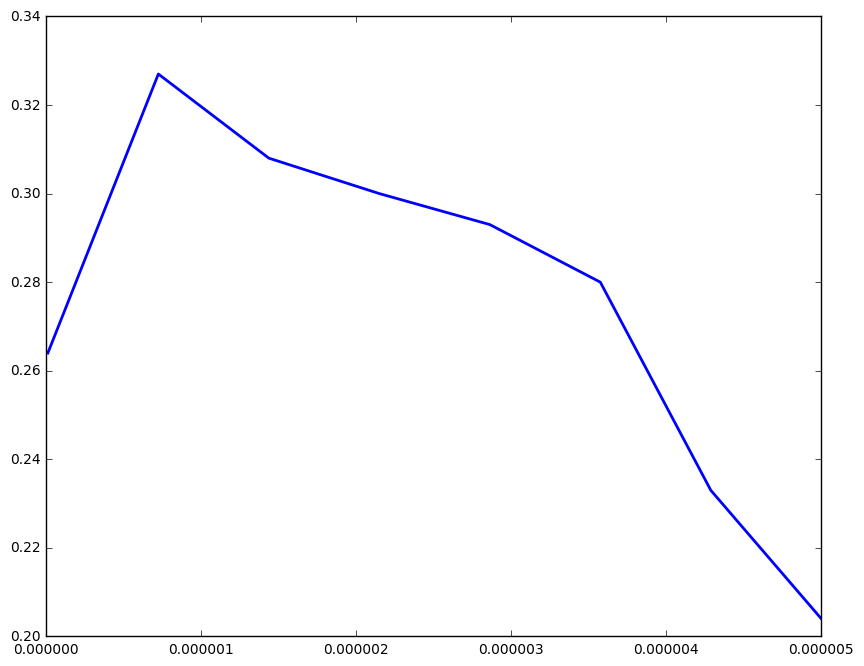

In [25]:
plt.plot(learning_rates,learn_array,linewidth=2.0)

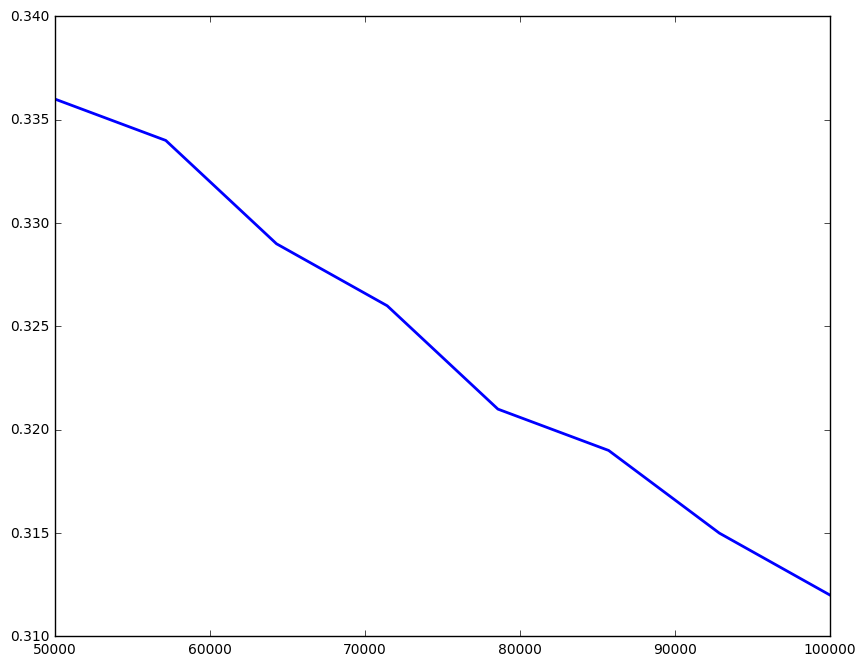

In [26]:
plt.plot(regularization,reg_array,linewidth=2.0)

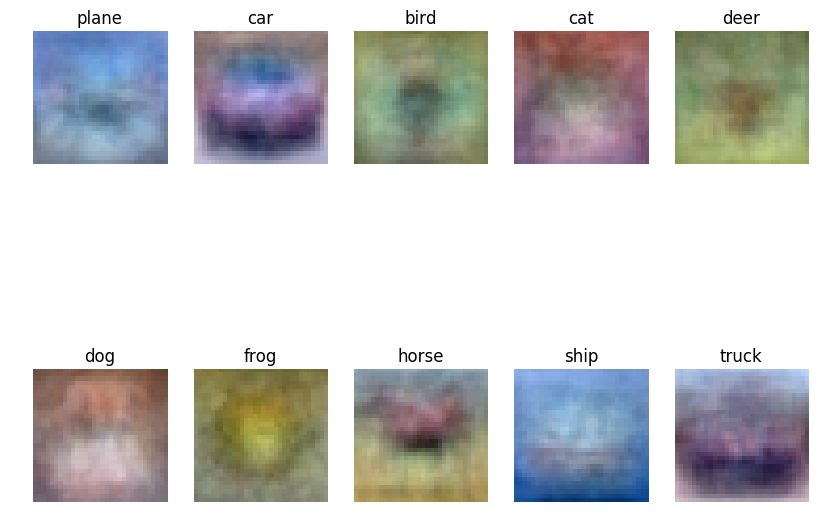

In [27]:
# CONSTRUCT SOFTMAX MODEL
best_learning_rate = learning_rates[np.argmax(learn_array)]
best_regularization_rate = regularization[np.argmax(reg_array)]
best_softmax = softmax(length,10)

# TRAIN MODEL - GET LOSS
loss = best_softmax.train(X_train,y_train,learning_rate=best_learning_rate,reg=best_regularization_rate)

# PRE-PROCESS WEIGHTS
w = best_softmax.model[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)

# PLOT
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])